In [1]:
__imp

Libraries have been loaded


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *
from torch.nn import functional as F

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
set_plot_sizes(12,14,16)

In [5]:
import torch

print(torch.cuda.is_available())

x = torch.rand(5, 3)
y = torch.rand(5, 3)
x = x.cuda()
y = y.cuda()
x + y

True


RuntimeError: cuda runtime error (8) : invalid device function at /pytorch/torch/lib/THC/generated/../generic/THCTensorMathPointwise.cu:301

### Load Data

In [5]:
PATH = '../data/interim/dataset1/application_train.pkl'

df_raw = pd.read_pickle(PATH)
df_raw = df_raw.sample(n=50000)

n_valid = int(.3 * 50000)
n_trn   = len(df_raw) - n_valid

In [6]:
cat_flds = [n for n in df_raw.drop('TARGET', axis=1).columns if df_raw[n].nunique()<n_trn/50]
' '.join(cat_flds)

'AMT_GOODS_PRICE AMT_REQ_CREDIT_BUREAU_DAY AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_MON AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_YEAR APARTMENTS_MODE CNT_CHILDREN CNT_FAM_MEMBERS CODE_GENDER DEF_30_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE ELEVATORS_AVG ELEVATORS_MEDI ELEVATORS_MODE EMERGENCYSTATE_MODE ENTRANCES_AVG ENTRANCES_MEDI ENTRANCES_MODE FLAG_CONT_MOBILE FLAG_DOCUMENT_10 FLAG_DOCUMENT_11 FLAG_DOCUMENT_12 FLAG_DOCUMENT_13 FLAG_DOCUMENT_14 FLAG_DOCUMENT_15 FLAG_DOCUMENT_16 FLAG_DOCUMENT_17 FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_2 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 FLAG_DOCUMENT_3 FLAG_DOCUMENT_4 FLAG_DOCUMENT_5 FLAG_DOCUMENT_6 FLAG_DOCUMENT_7 FLAG_DOCUMENT_8 FLAG_DOCUMENT_9 FLAG_EMAIL FLAG_EMP_PHONE FLAG_MOBIL FLAG_OWN_CAR FLAG_OWN_REALTY FLAG_PHONE FLAG_WORK_PHONE FLOORSMAX_AVG FLOORSMAX_MEDI FLOORSMAX_MODE FLOORSMIN_AVG FLOORSMIN_MEDI FLOORSMIN_MODE FONDKAPREMONT_MODE HOUR_APPR_PROCESS_START HOUSETYPE_MODE LIVE_CITY_NOT_WORK_CI

In [7]:
for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered()

In [8]:
cont_flds = [n for n in df_raw.drop('TARGET', axis=1).columns if n not in cat_flds]
' '.join(cont_flds)

'AMT_ANNUITY AMT_CREDIT AMT_INCOME_TOTAL APARTMENTS_AVG APARTMENTS_MEDI BASEMENTAREA_AVG BASEMENTAREA_MEDI BASEMENTAREA_MODE COMMONAREA_AVG COMMONAREA_MEDI COMMONAREA_MODE DAYS_BIRTH DAYS_EMPLOYED DAYS_ID_PUBLISH DAYS_LAST_PHONE_CHANGE DAYS_REGISTRATION EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 LANDAREA_AVG LANDAREA_MEDI LANDAREA_MODE LIVINGAPARTMENTS_AVG LIVINGAPARTMENTS_MEDI LIVINGAREA_AVG LIVINGAREA_MEDI LIVINGAREA_MODE NONLIVINGAREA_AVG NONLIVINGAREA_MEDI NONLIVINGAREA_MODE SK_ID_CURR TOTALAREA_MODE'

In [9]:
%%time
df, y, nas, mapper = proc_df(df_raw[cat_flds + cont_flds + ['TARGET']], 
                                   'TARGET', 
                                   do_scale=True, 
                                   skip_flds=['SK_ID_CURR'])

CPU times: user 1.44 s, sys: 103 ms, total: 1.55 s
Wall time: 1.55 s


In [10]:
%%time 

df_to_nn_train, df_to_nn_valid, y_train, y_valid = train_test_split(df, 
                                                                    y, 
                                                                    test_size=0.3, 
                                                                    random_state=SEED, 
                                                                    stratify = y)

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 46.7 ms


In [11]:
# md = ColumnarModelData.from_data_frame('../data/processed/', 
#                                        val_idx, 
#                                        df[cat_flds + cont_flds], 
#                                        y.astype('int'), 
#                                        cat_flds=cat_flds, 
#                                        bs=64
#                                       )

md  = ColumnarModelData.from_data_frames('../data/processed/', 
                                         trn_df = df_to_nn_train, 
                                         val_df = df_to_nn_valid, 
                                         trn_y = y_train.astype('int'), 
                                         val_y = y_valid.astype('int'), 
                                         cat_flds=cat_flds, 
                                         bs=64, 
                                         is_reg= False,
                                         is_multi=False
                                        )

# md = ColumnarModelData.from_data_frame('../data/processed/', 
#                                        val_idx, 
#                                        df, 
#                                        y.astype('int'), 
#                                        cat_flds=cat_flds, 
#                                        bs=64,
#                                        is_reg=False,
#                                        is_multi=False,
#                                        test_df=None)

In [12]:
emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c

{'AMT_GOODS_PRICE': 518,
 'AMT_REQ_CREDIT_BUREAU_DAY': 8,
 'AMT_REQ_CREDIT_BUREAU_HOUR': 4,
 'AMT_REQ_CREDIT_BUREAU_MON': 23,
 'AMT_REQ_CREDIT_BUREAU_QRT': 9,
 'AMT_REQ_CREDIT_BUREAU_WEEK': 8,
 'AMT_REQ_CREDIT_BUREAU_YEAR': 19,
 'APARTMENTS_MODE': 626,
 'CNT_CHILDREN': 12,
 'CNT_FAM_MEMBERS': 12,
 'CODE_GENDER': 4,
 'DEF_30_CNT_SOCIAL_CIRCLE': 8,
 'DEF_60_CNT_SOCIAL_CIRCLE': 8,
 'ELEVATORS_AVG': 170,
 'ELEVATORS_MEDI': 45,
 'ELEVATORS_MODE': 27,
 'EMERGENCYSTATE_MODE': 3,
 'ENTRANCES_AVG': 176,
 'ENTRANCES_MEDI': 45,
 'ENTRANCES_MODE': 31,
 'FLAG_CONT_MOBILE': 3,
 'FLAG_DOCUMENT_10': 3,
 'FLAG_DOCUMENT_11': 3,
 'FLAG_DOCUMENT_12': 2,
 'FLAG_DOCUMENT_13': 3,
 'FLAG_DOCUMENT_14': 3,
 'FLAG_DOCUMENT_15': 3,
 'FLAG_DOCUMENT_16': 3,
 'FLAG_DOCUMENT_17': 3,
 'FLAG_DOCUMENT_18': 3,
 'FLAG_DOCUMENT_19': 3,
 'FLAG_DOCUMENT_2': 3,
 'FLAG_DOCUMENT_20': 3,
 'FLAG_DOCUMENT_21': 3,
 'FLAG_DOCUMENT_3': 3,
 'FLAG_DOCUMENT_4': 3,
 'FLAG_DOCUMENT_5': 3,
 'FLAG_DOCUMENT_6': 3,
 'FLAG_DOCUMENT_7': 3,
 'FL

In [13]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]

In [14]:
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = torch.nn.NLLLoss(weight=torch.FloatTensor([0.1, 0.9]).cuda())

class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont= n_emb, n_cont
        szs = [n_emb + n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        x = []
        for i,e in enumerate(self.embs):
            x.append(e(x_cat[:,i]))
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn(x_cont)
        x = torch.cat([x, x2], 1)
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        x = F.log_softmax(x)
        return x

In [15]:
# m = MixedInputModel(emb_szs, n_cont = len(df.columns)-len(cat_flds),
#                     emb_drop = 0.05, out_sz = 2, szs = [100, 100, 100], drops = [0.05, 0.05, 0.05],
#                     y_range = None, 
#                     use_bn = False, 
#                     is_reg = False, 
#                     is_multi = False)
# bm = BasicModel(m.cuda(), 'binary_classifier')

In [16]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_flds),0.06, 2, [100,50], [0.03,0.06],None,True)

In [18]:
m.lr_find()

  0%|          | 0/547 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (8) : invalid device function at /pytorch/torch/lib/THC/THCTensorCopy.cu:204

In [17]:
m.lr_find()
m.sched.plot(100)

  0%|          | 0/547 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (8) : invalid device function at /pytorch/torch/lib/THC/THCTensorCopy.cu:204

In [17]:
learn.lr_find()
learn.sched.plot()

  0%|          | 0/1750 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (8) : invalid device function at /pytorch/torch/lib/THC/THCTensorCopy.cu:204

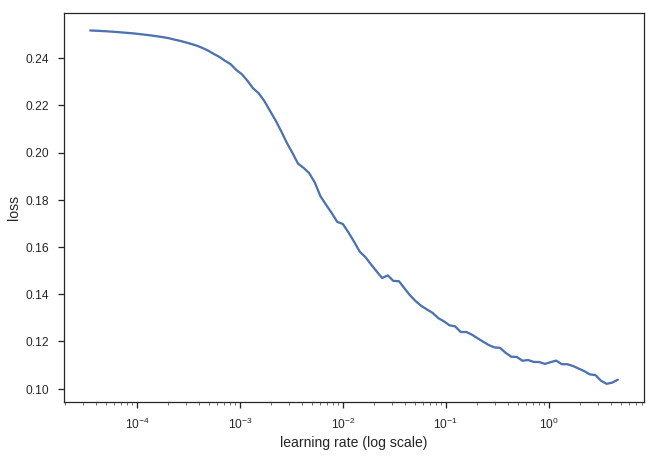

In [20]:
m.sched.plot()

In [23]:
lr=1e-3; wd=1e-7

In [24]:
m.fit(lr, 2, wd, cycle_len=1, cycle_mult=2)

[0.      0.92099 0.91685]                                    
[1.      0.92192 0.91685]                                    
[2.      0.92218 0.91685]                                    



In [25]:
m.fit(lr, 2, wd, cycle_len=2, cycle_mult=2)

[0.      0.92311 0.91685]                                    
[1.      0.92172 0.91685]                                    
[2.      0.91804 0.91685]                                    
[3.      0.91834 0.91685]                                    
[4.      0.91994 0.91685]                                    
[5.      0.92099 0.91685]                                    



In [31]:
pd.Series(m.predict()[:, 0]).value_counts()

1.0    3000
dtype: int64